<!-- dom:TITLE: Electric stimulation of a neuron in a virtual laboratory -->
# Electric stimulation of a neuron in a virtual laboratory
<!-- AUTHOR: Solveig Næss -->

<!-- DATE: today -->

<!-- TOC: on -->

<div class="alert alert-block alert-info">

This is a jupyter notebook. The notebook consists of text and code cells.
Each code cell can be run by clicking on the cell (gray box), before clicking the
play-button on the top of the page or pressing "shift + enter".

The code cells contain small programs written in the programming language Python.
We are going to use these programs for simulating nerve cell activity.
You don't need any prerequisite programming knowledge for doing these tasks.
Follow the instructions and ask the TAs for help whenever you have questions.

<div class="alert alert-block alert-info">
You will work in groups of three.

Start by making a copy of this file: Click on File; Make a copy.
Change the name of the file to: FamilynameFirstname_FamilynameFirstname_FamilynameFirstname_computinglab1.ipynb
If your group consist of Harry Potter, Kristine Bonnevie and Isaac Newton, your filename is:   PotterHarry_BonnevieKristine_NewtonIsaac_computinglab1.ipynb

This file should be handed in on CANVAS under Computational Lab 1: Neurosimulation

This computing lab consists of a virtual laboratory,
where we are going to stimulate a nerve cell with a sharp electrode.
We want to know how the membrane potential changes when we inject current into the cell.
Our goal is to understand how electric signals evolve over space and time in a neuron.

The experiments will be simulated with the modeling tools [LFPy](lfpy.github.io) and [NEURON](neuron.yale.edu).
These tools will divide the neuron into multiple compartments and represent each compartment by an electric circuit.
<!-- dom:FIGURE: [./figures/multicomp.png, height=400 width=600 frac=0.8] -->
<!-- begin figure -->

<p></p>
<img src="./figures/multicomp.png" height=400 width=600>

<!-- end figure -->

Then, the membrane potential $V_n$ can be calculated by solving the cable equation for compartment number $n$:


$C_m \frac{dV_n}{dt} = \frac{V_{n+1} - V_n}{R_i} - \frac{V_n - V_{n-1}}{R_i} + \frac{E_m - V_n}{R_m}$
<!-- $C_m \frac{\partial V_m(x, t)}{\partial t} = \frac{E_m - V_m(x, t)}{R_m} + \frac{d}{4 R_i} \frac{\partial^2 V_m}{\partial x^2}$ -->

This equation is derived from the fact that the sum of the current going into
one compartment equals the sum of the current going out of the compartment.
In words, the cable equation says that the membrane potential in compartment number $n$ in a neuron depends on the following factors:
* the resistance of the cell membrane, $R_m$, measured in Ohms ($\Omega$)

* the resistance of the cytoplasm $R_i$, measured in Ohms ($\Omega$)

* the diameter of the cell $d$, measured in meters (m)

* the capacitance of the cell membrane $C_m$, measured in Farads (F)

* the resting membrane potentential $E_m$, measured in volts (V)

* the membrane potential in the neighbor compartments $V_{n+1}$ and $V_{n-1}$, measured in volts (V).

<!-- --- begin exercise --- -->

## Exercise 1: Fill in the blanks
<div id="ex:v_mem"></div>


**a)**
Double click on the text below and replace the [----]s by choosing the correct words from the list below:

The __[----]__ separates ions in the cytoplasm from the extracellular fluid.
The separation of charge generates an electric voltage over the cell membrane.
This voltage is called the __[----]__ and is measured in the unit of __[----]__.
The axon has __[----]__ ion channels, which are necessary for regenerating an __[----]__ potential.

* *voltage*

* *membrane potential*

* *action*

* *capacitance*

* *voltage-gated*

* *amperes*

* *volts*

* *cell membrane*

(Click "play"/ "shift+enter", to make the text go back to normal.)


<!-- --- begin solution of exercise --- -->
**Solution.**
The *cell membrane* separates ions in the cytoplasm from the extracellular fluid.
The separation of charge generates an electric voltage over the cell membrane.
This voltage is called the *membrane potential* and is measured in the unit of *volts*.
The axon has *voltage-gated* ion channels, which are necessary for regenerating an *action* potential.

<!-- --- end solution of exercise --- -->

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 2: Injecting current into passive dendrite

Now we are going to simulate an electrophysiology experiment during which an
electrode injects electric current into a part of a neuron.

We are going to study how this current injection affects the membrane potential.
In order to visualize the difference between active and passive ion channels,
we are going to start by simulating a part of a neuron with passive ion channels only.
This means that there are **no voltage-gated ion channels** in this simulation.
You can think of this as a part of a passive dendrite.
A passive dendrite can be compared to a leaky water hose: similiar to water leaking out of the
holes in the water hose, electric currents will "leak out" of the passive ion channels.

Run the code cell below, in order to make python functions that can simulate the
neural activity in the dendrite and plot the results.

In [2]:
%matplotlib inline

from pylab import * # general plotting and computing
from matplotlib.collections import PolyCollection # extra fancy plotting
from ipywidgets import widgets, fixed # sliders
import LFPy # neural simulation
from neuron import h # neural simulation

# colors for plotting of electrodes
el_clrs = [matplotlib.cm.get_cmap('Set3')(i) for i in np.linspace(0,2,num=10)]

def plot_morph(ax, cell, input_locs=[0], color='k'):
    input_idcs = [cell.get_closest_idx(x=xloc, y=0, z=0) for xloc in input_locs]
    zips = []
    for x, z in cell.get_idx_polygons():
        zips.append(list(zip(x, z)))
    polycol = PolyCollection(zips,
                             edgecolors=color,
                             facecolors=color,
                             linewidths = cell.diam)

    ax.add_collection(polycol)

    for el_num, idx in enumerate(input_idcs):
        ax.plot(cell.xmid[idx], cell.zmid[idx]+1, 'v', color=el_clrs[el_num], ms=15)

    ax.set_ylim([-10, 12])

    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xlabel(r'x ($\mu$m)')
    ax.set_title('morphology')
    ax.set_xlim([-20,1020])


def plot_electrode_current(ax, cell, stim_electrodes):
    for el_num, electrode in enumerate(stim_electrodes):
        ax.plot(cell.tvec, electrode.i, color=el_clrs[el_num], ls='--', label='electrode ' + str(el_num+1))
    ax.set_xlabel('t (ms)')
    ax.set_ylabel(r'$I$(t) (nA)')
    ax.set_title('Injected current (t)')
    ax.set_xticks(np.linspace(0, 100, num=11))

def plot_membrane_potential_t(ax_v, ax_morph, cell, xloc):
    idx = cell.get_closest_idx(x=xloc, y=0, z=0)
    ax_morph.plot(cell.xmid[idx], cell.zmid[idx]-1, '^', color='gray', ms=15)
    ax_v.plot(cell.tvec, cell.vmem[idx,:])
    ax_v.set_xlabel('t (ms)')
    ax_v.set_ylabel(r'$V$(t) (mV)')
    ax_v.set_title('potential (t)')
    ax_v.set_ylim([-100, 50])
    ax_v.set_yticks(np.linspace(-100, 50, num=16))
    ax_v.set_xlim([0,100])

def plot_membrane_potential_x(ax, cell, t_point):
    '''plot potential as function of x'''
    t = int(t_point/cell.dt) # convert from time in (ms) to timepoint
    ax.plot(cell.xmid, cell.vmem[:,t])
    ax.set_ylabel('V(x) (mV)')
    ax.set_xlabel(r'x ($\mu$m)')
    ax.set_title('membrane potential (x)')
    ax.set_ylim([-100, 50])
    ax.set_yticks(np.linspace(-100, 50, num=16))
    ax.set_xlim([0,1000])

def plotting_cosmetics(fig):
    for ax in fig.axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(h_pad=-2)
    fig.set_size_inches(10., 10.)

def custom_fun():
    secnames = ''.join([sec.name() for sec in h.allsec()])
    if 'axon' in secnames:
        print('axon')
        h.axon[0].insert('hh')
        h.axon[1].insert('hh')
    if 'soma' in secnames:
        h.soma[0].insert('hh')


def simulate_cell(morphology, input_locs = [0], delays=[20], active=False, i_amp=1, i_dur = 5):
    num_electrodes = len(input_locs)
    if len(delays) == 0:
        delays = 20*np.ones(len(input_locs))
    if len(delays) != num_electrodes:
        raise AssertionError('You need the same number of input locations and delays! Try again.')

    # set synapse parameters
    r_m = 30000. # membrane resistance
    cell_parameters = {
        'morphology' : morphology,
        'cm' : 1.0,         # membrane capacitance
        'Ra' : 150.,        # axial resistance
        'v_init' : -70.,    # initial membrane potential
        'passive' : True,   # turn on NEURONs passive mechanism for all sections
        'passive_parameters' : {'g_pas' : 1./r_m, 'e_pas' : -70}, # e_pas = resting potential
        'nsegs_method': 'lambda_f',
        'dt' : 2.**-3,      # simulation time step size
        'tstart' : -100.,      # start time of simulation, recorders start at t=0
        'tstop' : 100.,     # stop simulation at 100 ms.
    }

    if active:
        cell_parameters['custom_fun'] = [custom_fun]
        cell_parameters['custom_fun_args'] = [{}]

    # create cell object
    cell = LFPy.Cell(**cell_parameters)
    cell.set_pos(x=-1000 + cell.xstart[0])


    if morphology == './cells/ball_n_stick.hoc':
        cell.set_pos(x = 500)
        cell.set_rotation(z = pi)
    # create electrode for stimulating cell
    pointprocess = {
        'record_current' : True,
        'pptype' : 'IClamp',
        'amp' : i_amp,
        'dur' : i_dur,
    }

    stim_electrodes = []
    for i in range(len(input_locs)):
        pointprocess['idx'] = cell.get_closest_idx(x=input_locs[i], y=0, z=0)
        pointprocess['delay'] = delays[i]
        stim_electrodes.append(LFPy.StimIntElectrode(cell, **pointprocess))

    # simulate cell
    cell.simulate(rec_imem=True, rec_vmem=True)

    return cell, stim_electrodes

def run_sim_and_plot(morphology, input_locs, active, timepoint, delays = []):
    cell, electrode = simulate_cell(morphology, input_locs, delays = delays, active=active)

    fig = figure()
    ax_morph = subplot2grid((2,1),(0,0))
    ax_v_x = subplot2grid((2,1),(1,0))

    # plot morph
    idcs = [cell.get_closest_idx(x=x_loc, y=0, z=0) for x_loc in input_locs]
    plot_morph(ax_morph, cell, input_idcs = idcs)
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    plotting_cosmetics(fig)

Run the code cell below to inject a $10$ ms step current of $0.3$ nA into a passive dendrite.
* The top plot shows the dendrite

* The colored triangle marks the electrode injecting current

* The gray triangle marks the electrode recording the membrane potential

* The middle plot shows the injected current as function of time

* The bottom shows the membrane potential in the dendrite at position $x = 100$

In [3]:
morphology = './cells/axon.hoc'
cell, electrodes = simulate_cell(morphology, i_amp = 0.3, i_dur = 10)

fig = figure()
ax_morph = subplot2grid((3,1),(0,0), colspan=2)
ax_i = subplot2grid((3,1),(1,0))
ax_v_t = subplot2grid((3,1),(2,0))

# plot morphology
plot_morph(ax_morph, cell, input_locs = [0])
# plot injected current as function of time
plot_electrode_current(ax_i, cell, electrodes)
# plot membrane potential where current is injected as function of time
x_rec = 100
plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
tittel = 'membrane potential at recording position x = ' + str(x_rec)
ax_v_t.set_title(tittel)
plotting_cosmetics(fig)
show()

AttributeError: 'Cell' object has no attribute 'xstart'

**a)**
How large is the membrane potential at location $x = 100 \mu$m before the current is switched on?

Double click on "Answer" below, to type in your answer. Click the "Play"-button/ press shift+enter to make the text go back to normal.

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
The initial membrane potential equals the resting membrane potential, e.i. $-70$mV.

<!-- --- end solution of exercise --- -->

**b)**
What happens to the membrane potential when the current is switched on? Why?

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
At rest, there is a higher concentration of positive ions outside of the cell as compared to inside of the cell, separated by the cell membrane. Sending a positive current into the cell can be thought of as sending positive charges into the cell. This will increase the concentration of positive ions inside of the cell, the charge difference between the inside and the outside of the cell will be reduced and the voltage over the cell membrane will be less negative. In other words, the cell membrane will be depolarized.

Since the cell membrane works as a (parallel plate) capacitor, we can think of injecting current into the cell as decharging the membrane capacitor, leading to a smaller voltage drop over the membrane capacitor.

<!-- --- end solution of exercise --- -->

**c)**
Why doesn't the membrane potential immediately return to its initial value?

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
After the electric current injection, the membrane potential will be larger than the membrane resting potenital. This will lead to a net movement of positive charge from the inside of the cell to the outside of the cell, until the membrane resting potential is restored. (You can think of this as the cell getting rid of the positive charges injected by the electrode.) This transportation of charges happens through the passive ion channels, and is a process that takes a bit of time.

<!-- --- end solution of exercise --- -->

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 3: How does the membrane potential spread through a passive dendrite?

Now we are going to look at how the membrane potential spreads spatially in our passive dendrite.
Run the code cell below, to make an interactive simulation showing the membrane potential ($V$)
as function of location ($x$).

Here, we inject a $0.3$ nA current lasting $10$ ms.

Change the timepoint shown in the figure by using the slider in one of the following ways:
* Drag the slider with the cursor

* Click on the slider, and move it with the arrow-keys

* Double-click on the number to the left of the slider and type in your chosen timepoint.

In [4]:
# define cell morphology
morphology = './cells/axon.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [0]
# set the time-points when you want each electrode to send electric input
delays = [20] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = False
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs=input_locs, delays = delays, active=active, i_dur=10, i_amp=0.3)

def make_vx_fig(timepoint):
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_x = subplot2grid((2,2),(1,0))

    # plot morph
    idcs = [cell.get_closest_idx(x=x_loc, y=0, z=0) for x_loc in input_locs]
    plot_morph(ax_morph, cell, input_locs = input_locs)
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.5, value=20.)
                         )

interactive(children=(FloatSlider(value=20.0, description='t (ms)', step=0.5), Output()), _dom_classes=('widge…

**a)**
Where (for which x-location on the axon) does the membrane potential reach the highest value? When does this happen?
NB: The simulation is lagging.. Go slow!

Answer:

Discuss with a fellow student:
How do your answers above relate to the location and time-course of the input current?


<!-- --- begin solution of exercise --- -->
**Solution.**
The membrane potential reaches the highest value at location $x = 0 \mu$m at time point $30$ ms. In other words, the membrane will be charged the most at the last point in time when the electrode is injecting current, at the exact location where the electrode is injecting current.

<!-- --- end solution of exercise --- -->

**b)**
How do you think the membrane potential $V(x)$-graph will look if the electrode is moved to the middle of the axon?

Answer:

You can change the electrode location by changing the following line in the code cell above:

`input_locs = [0.]`

The number inside the square brackets gives the x-position of the electrode. Change this so that the electrode is placed on the middle of the axon:

`input_locs = [500.]`

Run the code cell and discuss with a fellow student: Does the simulation match your assumptions? Explain why/ why not. If the simulation result didn't match your assumption, change your answer above.


<!-- --- begin solution of exercise --- -->
**Solution.**
The membrane potential will decay exponentially as a function of distance from the current injection location.

In [5]:
# define cell morphology
morphology = './cells/axon.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [500]
# set the time-points when you want each electrode to send electric input
delays = [20] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = False
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs=input_locs, delays = delays, active=active, i_dur=10, i_amp=0.3)

def make_vx_fig(timepoint):
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_x = subplot2grid((2,2),(1,0))

    # plot morph
    idcs = [cell.get_closest_idx(x=x_loc, y=0, z=0) for x_loc in input_locs]
    plot_morph(ax_morph, cell, input_locs = input_locs)
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.5, value=30.)
                         )

interactive(children=(FloatSlider(value=30.0, description='t (ms)', step=0.5), Output()), _dom_classes=('widge…

<!-- --- end solution of exercise --- -->


<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 4: How does the dendrite diameter affect the membrane potential?

In this exercise we are going to stimulate two dendrites:
one dendrite with diameter $d = 2 \mu m$ and a thicker dendrite
with diameter $d = 4 \mu m$. The current injected into each cell lasts $10$ ms and has an amplitude of $0.3$ nA.


**a)**
Discuss with a fellow student: Will increasing the diameter make the membrane potential decay slower or more rapidly with distance from input location?

Run the code cell below:

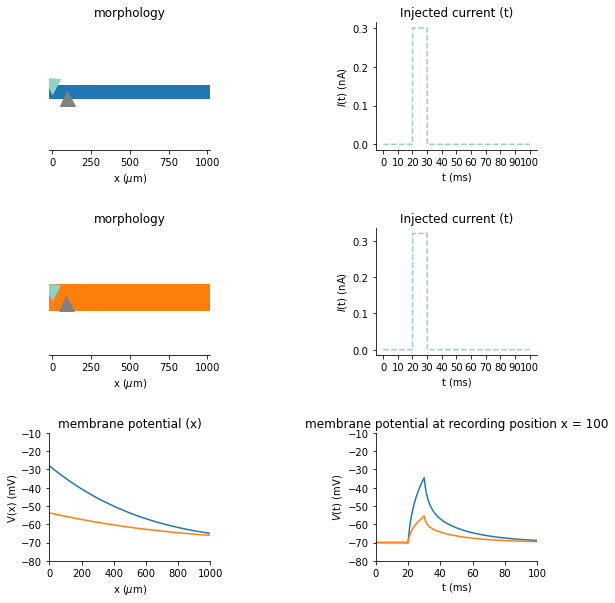

In [6]:
# define cell morphologies
morphology_thin = './cells/axon.hoc'
morphology_thick = './cells/axon_thick.hoc'
# simulate cells
# i_amp sets the amplitude of the current injection in (nA)
axon, stim_electrodes1 = simulate_cell(morphology_thin, [0.], i_dur = 10, i_amp=.3)
axon_thick, stim_electrodes2 = simulate_cell(morphology_thick, [0.], i_dur = 10, i_amp=.32)

# create figure comparing the two simulations
fig = figure()
ax_morph1 = subplot2grid((3,2), (0,0))
ax_morph2 = subplot2grid((3,2), (1,0))
ax_v_x = subplot2grid((3,2), (2,0))
ax_i1 = subplot2grid((3,2), (0,1))
ax_i2 = subplot2grid((3,2), (1,1))
ax_v_t = subplot2grid((3,2), (2,1))

# plot axon morphologies
c_thin = 'C0'
c_thick = 'C1'
plot_morph(ax_morph1, axon, input_locs = [0], color=c_thin)
plot_morph(ax_morph2, axon_thick, input_locs = [0], color=c_thick)
# plot injected currents as function of time
plot_electrode_current(ax_i1, axon, stim_electrodes1)
plot_electrode_current(ax_i2, axon_thick, stim_electrodes2)
# plot membrane potential where current is injected as function of time
x_rec = 100
plot_membrane_potential_t(ax_v_t, ax_morph1, axon, x_rec)
plot_membrane_potential_t(ax_v_t, ax_morph2, axon_thick, x_rec)
tittel = 'membrane potential at recording position x = ' + str(x_rec)
ax_v_t.set_title(tittel)
ax_v_t.set_ylim([-80., -10])
# plot membrane potential at time point 21 ms as function of axon length.
plot_membrane_potential_x(ax_v_x, axon, 30)
plot_membrane_potential_x(ax_v_x, axon_thick, 30)
ax_v_x.set_ylim([-80., -10])
plotting_cosmetics(fig)
show()

**b)**
How does the membrane potential in the thick dendrite differ from the membrane potential in the thin dendrite?
Which changes could be done to our experiment, in order to make the membrane potential response look more similar for the two different dendrites?

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
When injecting the same current into a thin and a thick dendrite, the membrane potential in the thin dendrite will be more depolarized than the membrane potential in the thick dendrite. We could inject more current into the thick dendrite, in order to make the membrane potential response more similar for the two dendrites.

<!-- --- end solution of exercise --- -->

Change the amplitude of the current injected into the thick dendrite,
to make orange $V(x)$-curve more similar to the blue one.

You can do this by changing the very last number in the following line:

`axon_thick, stim_electrodes2 = simulate_cell(morphology_thick, [0.], i_dur = 10, i_amp=.3)`

such that `i_amp = ` 
some number between 0 and 1.

**c)**
Why did you have to increase/decrease the input current into the thick dendrite in order to get similar membrane potential amplitudes?

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
When increasing the amplitude of the current injected into the thick dendrite to `i_amp = 0.82 nA`, we get similar membrane potential amplitudes for the thin and the thick dendrite. A thicker dendrite has a larger cell membrane, which means that the membrane capacitance will be larger, and we need more current to charge a large capacitor, compared to a small capacitor. A thicker cell will also have a lower membrane resistance and a lower axial resistance. This means that it is easier for the current to escape, and it is harder to generate a difference in charge concentration.

<!-- --- end solution of exercise --- -->

**d)**
Now that the amplitudes of the V(x)-curves for the thin (blue) and the thick (orange) dendrites are more similar, compare the shapes of the two curves. Give a short explanation of the difference. Do your results agree with your assumptions in 4a?

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
Increasing the dendrite diameter will decrease the inner resistance of the dendrite. (The membrane resistance will also be reduced, but not as much as the inner resistance.) This will make it easier for the current to flow inside of the dendrite, compared to leaking out through the membrane. Eventually, all the extra, positive charges injected by the current will leak out of the dendrite into the extracellular medium. In a thicker dendrite, more current will spread through the dendrite and escape into the extracellular medium further away from the electrode. This means that injecting current into a thick dendrite will have a larger effect on the membrane potential in the parts of the dendrite further away from the injection site (since more current will flow inside of the dendrite to these neighboring parts, instead of immediately escaping the cell). While in a thin dendrite, most of the current will escape the cell very close to the injection site, meaning that less current will enter the other parts of the dendrite, leading to a steeper decay in membrane potential as a function of distance from the input electrode.
<!-- The membrane potential decays more rapidly with distance from the input electrode in a thin dendrite, than in a thick dendrite. The membrane resistance ($R_m$) is inversely proportional to the diameter of the dendrite ($R_m \propto \frac{1}{d}$), while the inner resistance ($R_i$) is proportional to the square of the diameter ($R_i \propto \frac{1}{d^2}$). A thick dendrite with twice as large diameter as a thin dendrite, will therefore have 50% of the membrane resistance and only 25% of the inner resistance of the thin dendrite! This means that it will be relatively easier for the current to flow inside the cell than to leak out through the passive ion channels. In a thin dendrite most of the current will leak out of the -->

<!-- --- end solution of exercise --- -->



<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 5: Active cable

Now we are going to insert voltage-gated ion channels into our neuron model, such that it represents a part of an axon, instead of part of a dendrite.

In the code cell below, the line:

*active = False*

is changed to

*active = True*.


Run the code cell in order to insert a $7$ nA input current lasting $1$ ms into the $4 \mu$m thick axon:

In [1]:
# define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [0] #µm
# set the time-points when you want each electrode to send electric input
delays = [20] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=7.)
# set the x-location for where you want to plot V(t)
def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1500])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    ax_v_t.axhline(30, ls=':', color='k')
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_v_x.set_xlim([0, 1500])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=20.)
                         )

NameError: name 'simulate_cell' is not defined

**a)**
Use the slider to simulate how an action potential propagates through the axon.
Describe the differences between an action potential and a graded potential in terms of how they
* develop in space (for a specific time point) and

* develop in time (for a specific point in space)

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
An action potential is regenerative, and can propagate down axons (in space) without any loss of shape or amplitude. A graded potential, on the other hand, will decay exponentially as a function of distance from current input (or synaptic input), since there are no active ion channels regenerating the signal.

While the action potential lasts a few milliseconds, a graded potential takes much longer to decay back to the resting membrane potential. The opening of active ion channels during an action potential will make the cell membrane more permeable (easier for ions to go through), which leads to faster restoring of the resting membrane potential. During a graded potential no active ion channels are open, and the only way for the ions to flow through the membrane is through the passive channels. Due to fewer open ion channels, the cell membrane is less permeabel during a graded potential, and it will take longer time for the ions to leak through the membrane and restore the resting membrane potential.

<!-- --- end solution of exercise --- -->

<!-- !bsubex -->
<!-- The distance between two nodes of ranvier can be up to $1.5$ mm. -->
<!-- Would you say that this action potential is shorter than or longer than the distance between two Ranvier nodes? -->
<!--  -->
<!-- !bc -->
<!-- !ec -->
<!-- !bblock -->
<!-- Answer: -->
<!-- !eblock -->
<!-- !bc -->
<!-- !ec -->
<!--  -->
<!-- !bsol -->
<!-- By using the slider you can see that more than $1.5$ mm of the axon will have an membrane potential above threshold $\sim -55$mV. This means that this action potential has a spatial reach that is longer than the distance between two nodes of Ranvier. -->
<!-- !esol -->
<!-- !esubex -->


**b)**
By adding a second electrode, we can stimulate the axon at two locations at the same time.

What happens when two action potentials meet?

Answer:

Add another electrode to the simulation, such that we stimulate the axon at two locations at the same time,
by changing the code lines setting the input locations and the delays.

`input_locs = [0., 1500.]`

`delays = [20., 20.]`

Here, `input_locs` decides where the electrodes are placed on the axon.
`delays` decides the time point when the corresponding electrode should give an electric input.
Meaning that the code above inserts two electrodes:
* One electrode at location $x = 0 \mu$m which injects an electric current after 20 ms.

* One electrode at location $x = 1500 \mu$m which also injects a current after 20 ms.

Run the code cell and use the slider to check whether your answer above is correct.


<!-- --- begin solution of exercise --- -->
**Solution.**
By running the simulation below and using the slider, we can see that two action potentials will annihilate each other when they meet. A part of an axon that just regenerated an action potential will not be ready to fire a new action potential before the $\text{Na}^+$-gates have been reset to their resting positions, i.e until the absolute refractory period is over.

In [43]:
##### define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [-500, 2000] #µm
# set the time-points when you want each electrode to send electric input
delays = [20, 20] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=7.)
# set the x-location for where you want to plot V(t)
def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1500])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    ax_v_t.axhline(30, ls=':', color='k')
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_v_x.set_xlim([-2000, 3500])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=20.)
                         )

axon


interactive(children=(FloatSlider(value=20.0, description='t (ms)', step=0.2), Output()), _dom_classes=('widge…

<!-- --- end solution of exercise --- -->




**c)**
How long time does it take from an action potential onset until the relative refractory period has passed? (How long is the absolute refractory period + the relative refractory period?)

Answer:

<!-- --- begin hint in exercise --- -->

**Hint.**
Place the two electrodes at the same location, and alter the time points (`delays`).
How long do we need to wait from one stimulation to the next in order to generate two equally large action potentials?

<!-- --- end hint in exercise --- -->


<!-- --- begin solution of exercise --- -->
**Solution.**
After generating an action potential by injecting a current pulse into the cell, another equal current pulse can only result in another action potential with the same amplitude as the first one, if we wait with the second input current until both the absolute refractory period and the relative refractory period have passed. Since we don't know how long the absolute refractory period is, we cannot compute the exact duration of the relative refractory period.

By running the simulation below, we find that we need to wait $\sim 14$ ms before injecting the second current, in order to generate two action potentials with the same amplitude. This means that the relative refractory period is finished after about $14$ ms.

In [41]:
# define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [0, 0] #µm
# set the time-points when you want each electrode to send electric input
delays = [20, 34] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=7.)
# set the x-location for where you want to plot V(t)
def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1500])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    ax_v_t.axhline(30, ls=':', color='k')
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_v_x.set_xlim([0, 1500])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=20.)
                         )

axon


interactive(children=(FloatSlider(value=20.0, description='t (ms)', step=0.2), Output()), _dom_classes=('widge…

<!-- --- end solution of exercise --- -->


<!-- !bsubex -->
<!-- Discuss with a fellow student: Will the action potential travel faster or slower in a thicker axon? -->
<!--  -->
<!-- !bc -->
<!-- Answer: -->
<!-- !ec -->
<!--  -->
<!-- You can test your answer by changing the morphology above between -->
<!-- ´morphology = './cells/axon.hoc'´ -->
<!-- and -->
<!-- ´morphology = './cells/axon_thick.hoc'´ -->
<!-- and check how much time it takes for the action potential to propagate from one end of the axon to the other by using the time slider. -->
<!--  -->
<!-- !bhint -->
<!-- Here, you only need one electrode placed at input location `input_locs = [0]`. -->
<!-- !ehint -->
<!--  -->
<!-- !bc pycod -->
<!-- Answer: -->
<!-- !ec -->

<!-- !esubex -->

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 6: Temporal summation

Now we are going to inject three currents into the left end of the axon.
All injections last $1$ ms, have amplitudes of $2.5$ nA and there is $20$ ms between the start of each input.

Run the code cell below:

In [28]:
# define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [0, 0, 0] #µm
# set the time-points when you want each electrode to send electric input
delays = [0, 2, 4] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=2.5)
# set the x-location for where you want to plot V(t)
x_to_plot = -1 # int

def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1050])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    ax_i.set_xlim([0, 50])
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    tittel = 'membrane potential at rec pos x = ' + str(x_rec)
    ax_v_t.set_title(tittel)
    ax_v_t.axhline(30, ls=':', color='k')
    ax_v_t.set_xlim([0, 50])
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_v_x.set_xlim([-50, 1050])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=0.)
                         )

axon


interactive(children=(FloatSlider(value=0.0, description='t (ms)', step=0.2), Output()), _dom_classes=('widget…

**a)**
What is the largest time interval between the current inputs that will generate an action potential?

Answer:

<!-- --- begin hint in exercise --- -->

**Hint.**
Change the input time points in the following code line:
`delays = [0, 20, 40] # between 0 and 100 ms`

<!-- --- end hint in exercise --- -->


<!-- --- begin solution of exercise --- -->
**Solution.**
$\sim 2$ ms.

In [44]:
# define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [0, 0, 0] #µm
# set the time-points when you want each electrode to send electric input
delays = [0, 2, 4] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=2.5)
# set the x-location for where you want to plot V(t)
x_to_plot = -1 # int

def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1050])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    ax_i.set_xlim([0, 50])
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    tittel = 'membrane potential at rec pos x = ' + str(x_rec)
    ax_v_t.set_title(tittel)
    ax_v_t.axhline(30, ls=':', color='k')
    ax_v_t.set_xlim([0, 50])
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_v_x.set_xlim([-50, 1050])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=0.)
                         )

axon


interactive(children=(FloatSlider(value=0.0, description='t (ms)', step=0.2), Output()), _dom_classes=('widget…

<!-- --- end solution of exercise --- -->


**b)**
Give a short explanation of the term "temporal summation".

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
Graded potenitals sum linearly. This means that if two graded potentials overlap in time and space, we get the total membrane potential by summing the two graded potentials. Temporal summation refers to when a single synapse receives inputs that are so close in time that the graded potential from the first input has not decayed all the way down to the resting membrane potential when the second input occurs. This way the membrane potential already has a head start when the second one occurs, and two (or more) graded potentials that are close in time can depolarize the cell membrane more than what one single input can do.


One single synaptic input is normally not enough to bring the membrane potential in the soma up to threshold. A burst of inputs to one single synapse can by spatial summation lead to an action potential.

<!-- --- end solution of exercise --- -->

<!-- --- end exercise --- -->




<!-- --- begin exercise --- -->

## Exercise 7: Spatial summation

Now we are going to inject two currents into the axon simultaneously.
The inputs lasts $1$ ms and the current amplitudes are $2$ nA.

Run the code cell below:

In [88]:
# define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [3000] #µm
# set the time-points when you want each electrode to send electric input
delays = [0] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=2.)
# set the x-location for where you want to plot V(t)
x_to_plot = -1 # int

def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1050])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    ax_i.set_xlim([0, 50])
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    tittel = 'membrane potential at rec pos x = ' + str(x_rec)
    ax_v_t.set_title(tittel)
    ax_v_t.axhline(30, ls=':', color='k')
    ax_v_t.set_xlim([0, 50])
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_morph.set_xlim([-50,1050])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=0.)
                         )

axon


interactive(children=(FloatSlider(value=0.0, description='t (ms)', step=0.2), Output()), _dom_classes=('widget…

**a)**
What is the largest spatial distance between the electrode inputs that can result in an action potential?

Answer:

<!-- --- begin hint in exercise --- -->

**Hint.**
Change the input locations in the following code line:
`input_locs = [0, 1000] #µm`

<!-- --- end hint in exercise --- -->


<!-- --- begin solution of exercise --- -->
**Solution.**
$\sim 448 \mu$m.

In [11]:
# define cell morphology
morphology = './cells/axon_thick10.hoc'
# set the x-coordinate where you want the axon to get electric input
input_locs = [0, 448] #µm
# set the time-points when you want each electrode to send electric input
delays = [0, 0] # between 0 and 100 ms
# decide whether to insert active ion channels or not
active = True
# simulate current injection into cell
cell, electrodes = simulate_cell(morphology, input_locs, delays = delays, active=active, i_dur = 1, i_amp=2.)
# set the x-location for where you want to plot V(t)
x_to_plot = -1 # int

def make_vx_fig(timepoint):
    close('all')
    fig = figure()
    ax_morph = subplot2grid((2,2),(0,0))
    ax_v_x = subplot2grid((2,2),(1,0))
    ax_i = subplot2grid((2,2), (0,1))
    ax_v_t = subplot2grid((2,2),(1,1))

    # plot morph
    plot_morph(ax_morph, cell, input_locs = input_locs)
    ax_morph.set_xlim([-50,1050])
    ax_morph.set_ylim([-20, 40])
    # plot I(t)
    plot_electrode_current(ax_i, cell, electrodes)
    ax_i.set_xlim([0, 50])
    # plot V(t)
    x_rec = 100
    plot_membrane_potential_t(ax_v_t, ax_morph, cell, x_rec)
    tittel = 'membrane potential at rec pos x = ' + str(x_rec)
    ax_v_t.set_title(tittel)
    ax_v_t.axhline(30, ls=':', color='k')
    ax_v_t.set_xlim([0, 50])
    # plot V(x)
    plot_membrane_potential_x(ax_v_x, cell, timepoint)
    ax_morph.set_xlim([-50,1050])
    plotting_cosmetics(fig)


slider = widgets.interact(make_vx_fig,
                          timepoint=widgets.FloatSlider(description='t (ms)', min=0, max=100., step=0.2, value=0.)
                         )

axon


interactive(children=(FloatSlider(value=0.0, description='t (ms)', step=0.2), Output()), _dom_classes=('widget…

<!-- --- end solution of exercise --- -->


**b)**
Give a short explanation of the term "spatial summation".

Answer:

<!-- --- begin solution of exercise --- -->
**Solution.**
A graded potential decays exponentially with distance. Spatial summation refers to when two synapses placed on different locations on a neuron, are placed close enough for the graded potentials from the two synapses to "meet" and depolarize the same part of the membrane at the same time. When two such synapses receive input at roughly the same time point, some part of the neuron will experience more depolarization, than what could have been caused by a single synapse.

One single synaptic input is normally not enough to bring the membrane potential in the soma up to threshold. Many synapses receiving input at roughly the same time can by spatial summation cause a stronger depolarization in the soma and lead to an action potential.

<!-- --- end solution of exercise --- -->


Source: Principles of Computational Modelling in Neuroscience, Sterratt et al. 2011



<!--  -->
<!-- ===== Exercise: Nerve conduction in a passive neural cable ===== -->
<!--  -->
<!--  -->
<!--  -->
<!-- In this exercise we are going to investigate how various properties of a -->
<!-- neuron affect the conduction of an electric signal. -->
<!--  -->
<!-- * Diameter (d) -->
<!-- * Membrane resistance (r_m) -->
<!-- * Membrane capacitance (c_m ) -->
<!-- * Axial resistance (r_a) -->
<!--  -->
<!--  -->
<!-- We will start by simulating a very simplified cell model, that is a neural cable. -->
<!--  -->
<!--  -->
<!-- We start by loading some packages that can help us simulate neural activity, -->
<!-- and plot the results. -->
<!--  -->
<!-- !bc pycod -->
<!-- from pylab import * # general plotting and computing -->
<!-- from matplotlib.collections import PolyCollection # extra fancy plotting -->
<!-- import LFPy # neural simulation -->
<!-- from neuron import h # neural simulation -->
<!-- !ec -->
<!--  -->
<!-- In the following code cell we load the cell that we want to simulate. -->
<!-- !bc pycod -->
<!-- morphology = './cells/axon.hoc' -->
<!-- !ec -->
<!--  -->
<!-- Below you see a function that injects a step current -->
<!-- into one end of the cell, and simulates the cell as a series of RC-circuits. -->
<!-- Run the code cell by clicking on the code cell, before typing shift+enter. -->
<!--  -->
<!-- !bc pycod -->
<!-- def simulate_cell(morphology): -->
<!-- # set synapse parameters -->
<!-- r_m = 30000. # membrane resistance -->
<!-- cell_parameters = { -->
<!-- 'morphology' : morphology, -->
<!-- 'cm' : 1.0,         # membrane capacitance -->
<!-- 'Ra' : 150.,        # axial resistance -->
<!-- 'v_init' : -65.,    # initial membrane potential -->
<!-- 'passive' : True,   # turn on NEURONs passive mechanism for all sections -->
<!-- 'passive_parameters' : {'g_pas' : 1./r_m, 'e_pas' : -65}, # e_pas = resting potential -->
<!-- 'nsegs_method': 'lambda_f', -->
<!-- 'dt' : 2.**-3,      # simulation time step size -->
<!-- 'tstart' : 0.,      # start time of simulation, recorders start at t=0 -->
<!-- 'tstop' : 100.,     # stop simulation at 100 ms. -->
<!-- } -->
<!--  -->
<!-- # setup for active cell -->
<!-- active_segments = False -->
<!--  -->
<!--  -->
<!-- if active_segments: -->
<!-- cell_parameters['custom_fun'] = [custom_fun] -->
<!-- cell_parameters['custom_fun_args'] = [{}] -->
<!--  -->
<!-- # create cell object -->
<!-- cell = LFPy.Cell(**cell_parameters) -->
<!--  -->
<!-- # create electrode for stimulating cell -->
<!-- pointprocess = { -->
<!-- 'idx' : 0, -->
<!-- 'record_current' : True, -->
<!-- 'pptype' : 'IClamp', -->
<!-- 'amp' : 1, -->
<!-- 'dur' : 10, -->
<!-- 'delay' : 20, -->
<!-- } -->
<!--  -->
<!-- stim_electrode = LFPy.StimIntElectrode(cell, **pointprocess) -->
<!--  -->
<!-- # simulate cell -->
<!-- cell.simulate(rec_imem=True, rec_vmem=True) -->
<!-- return cell, stim_electrode -->
<!-- !ec -->
<!--  -->
<!-- In the following code cell, there is a function for plotting of cell morphology, -->
<!-- injected current and membrane potential. Run the code cell. -->
<!--  -->
<!-- !bc pycod -->
<!-- def plot_morph(ax, cell, input_idx=0): -->
<!-- zips = [] -->
<!-- for x, z in cell.get_idx_polygons(): -->
<!-- zips.append(list(zip(x, z))) -->
<!-- polycol = PolyCollection(zips, -->
<!-- edgecolors='k', -->
<!-- facecolors='k', -->
<!-- linewidths = cell.diam) -->
<!--  -->
<!-- ax.add_collection(polycol) -->
<!-- ax.plot(cell.xmid[input_idx], cell.zmid[input_idx], 'rv', ms=10) -->
<!-- ax.set_ylim([-10, 12]) -->
<!--  -->
<!-- ax.spines['left'].set_visible(False) -->
<!-- ax.set_yticklabels([]) -->
<!-- ax.set_yticks([]) -->
<!-- ax.set_xlabel(r'x ($\mu$m)') -->
<!-- ax.set_title('morphology') -->
<!--  -->
<!-- def plot_electrode_current(ax, cell, stim_electrode): -->
<!-- ax.plot(cell.tvec, stim_electrode.i, 'r') -->
<!-- ax.set_xlabel('t (ms)') -->
<!-- ax.set_ylabel(r'$I$(t) (nA)') -->
<!-- ax.set_title('Injected current (t)') -->
<!--  -->
<!-- def plot_membrane_potential_t(ax, cell, idx): -->
<!-- ax.plot(cell.tvec, cell.vmem[idx,:]) -->
<!-- ax.set_xlabel('t (ms)') -->
<!-- ax.set_ylabel(r'$V$(t) (mV)') -->
<!-- ax.set_title('potential (t)') -->
<!-- ax.set_ylim([-70, 250]) -->
<!--  -->
<!-- def plotting_cosmetics(fig): -->
<!-- for ax in fig.axes: -->
<!-- ax.spines['top'].set_visible(False) -->
<!-- ax.spines['right'].set_visible(False) -->
<!-- fig.tight_layout(pad=0.5, h_pad=1., w_pad=.7) -->
<!--  -->
<!-- def plotting(cell, stim_electrode): -->
<!-- # plot morphology -->
<!-- fig = figure() -->
<!-- ax_morph = subplot2grid((2,2),(0,0), colspan=2) -->
<!-- ax_i = subplot2grid((2,2),(1,0)) -->
<!-- ax_v_t = subplot2grid((2,2),(1,1)) -->
<!--  -->
<!-- # plot morphology -->
<!-- idx_i=0 # compartment where current is injected -->
<!-- plot_morph(ax_morph, cell, input_idx = idx_i) -->
<!--  -->
<!-- # plot injected current as function of time -->
<!-- plot_electrode_current(ax_i, cell, stim_electrode) -->
<!--  -->
<!-- # plot membrane potential where current is injected as function of time -->
<!-- plot_membrane_potential(ax_v_t, cell, idx_i) -->
<!--  -->
<!-- # cosmetics -->
<!-- plotting_cosmetics(fig) -->
<!-- show() -->
<!-- !ec -->
<!--  -->
<!-- Now, we will use the functions above for simulating a neural cable with a -->
<!-- an injected current and plotting the results. -->
<!--  -->
<!-- !bc pycod -->
<!-- morphology = './cells/axon.hoc' -->
<!-- cell, stim_electrode = simulate_cell(morphology) -->
<!-- plotting(cell, stim_electrode) -->
<!-- !ec -->
<!--  -->
<!-- !bsubex -->
<!-- If we increase the diameter of the neuron, do you think the membrane potential -->
<!-- will decrease or increase? Discuss with your neighbor, -->
<!-- and write down the answer below: -->
<!--  -->
<!--  -->
<!-- !bc -->
<!-- Answer: -->
<!-- !ec -->
<!--  -->
<!-- Now, test your hypothesis by varying the morphology between './cells/axon_thin.hoc', -->
<!-- './cells/axon.hoc' and './cells/axon_thick.hoc', which have $d=1$, $d=2$ and -->
<!-- $d=10~~\mu m$, respectively. -->
<!--  -->
<!-- !bc pycod -->
<!-- morphology = './cells/axon_thick.hoc' -->
<!-- cell, stim_electrode = simulate_cell(morphology) -->
<!-- plotting(cell, stim_electrode) -->
<!-- !ec -->
<!--  -->
<!-- !esubex -->
<!--  -->
<!-- !bsubex -->
<!-- The membrane consists of a lipid bilayer that separates ions in the extracellular -->
<!-- space from the intracellular space. Membrane functions as capacitor. Will a -->
<!-- large membrane capacitance contribute to a higher or lower membrane potential? -->
<!-- Discuss with your neighbor and write down the answer below. -->
<!--  -->
<!-- !bc -->
<!-- Answer: -->
<!-- !ec -->
<!--  -->
<!-- Now, test your hypothesis by changing the membrane capacitance in the function -->
<!-- `simulate_cell`, and plot the results by running the code cell below. -->
<!-- Was your assumptions correct? Why/ why not? -->
<!--  -->
<!-- !bc pycod -->
<!-- morphology = './cells/axon.hoc' -->
<!-- cell, stim_electrode = simulate_cell(morphology) -->
<!-- plotting(cell, stim_electrode) -->
<!-- !ec -->
<!--  -->
<!-- !esubex -->
<!--  -->
<!-- !bsubex -->
<!-- Now we are going to study how the membrane potential spreads in our passive neuron cable. -->
<!-- The code below plots the morphology and the potential as a function of x. -->
<!-- !esubex -->
<!--  -->
<!-- !bc pycod -->
<!-- morphology = './cells/axon.hoc' -->
<!-- cell, stim_electrode = simulate_cell(morphology) -->
<!--  -->
<!-- fig = figure() -->
<!-- ax_morph = subplot2grid((2,1),(0,0)) -->
<!-- ax_v_x = subplot2grid((2,1),(1,0)) -->
<!--  -->
<!-- # plot morphology -->
<!-- plot_morph(ax_morph, cell, 0) -->
<!--  -->
<!--  -->
<!-- # plot potential as function of x -->
<!-- def plot_membrane_potential_t(ax, cell, t_point): -->
<!-- ax.plot(cell.xmid, cell.vmem[:,t]) -->
<!-- ax.set_ylabel('V(x) (mV)') -->
<!-- ax.set_xlabel(r'x ($\mu$m)') -->
<!-- ax.set_title('potential (x)') -->
<!-- ax.set_ylim([-70, 200]) -->
<!--  -->
<!-- #timepoint for plotting V(x) -->
<!-- t_ms = 25 -->
<!-- t = int(t_ms/cell.dt) -->
<!-- plot_membrane_potential_t(ax_v_x, cell, t) -->
<!-- plotting_cosmetics(fig) -->
<!-- show() -->
<!-- !ec -->
<!--  -->
<!-- * Change the timepoint, to see how the potential over the whole axon changes -->
<!-- with time. -->
<!--  -->
<!-- !bsubex -->
<!-- Leaky cable. -->
<!-- In the `simulate_cell`-function we set the cell parameters in a dictionary. -->
<!-- Change the axial resistance and the membrane resistance, to see how these affect -->
<!-- how the membrane potential decays with distance. -->
<!-- !esubex -->
<!--  -->
<!-- !bc pycod -->
<!-- fig = figure() -->
<!-- ax_morph = subplot2grid((2,1),(0,0)) -->
<!-- ax_v_x = subplot2grid((2,1),(1,0)) -->
<!-- plot_morph(ax_morph, cell, 0) -->
<!-- plot_membrane_potential_t(ax_v_x, cell, t) -->
<!-- plotting_cosmetics(fig) -->
<!-- show() -->
<!-- !ec -->
<!--  -->
<!-- ===== Exercise: Nerve conduction in active neural cable ===== -->
<!-- Till now we have been working with a passive neuron model, -->
<!-- i.e. the cable contained only leak ion channels and could not generate or regenerate an action potential. -->
<!-- Now we are going to insert active ion channels into our model, and study the conduction of an action potential. -->
<!-- We start by making a function for simulating an active cell. -->
<!-- !bc pycod -->
<!-- def custom_fun(): -->
<!-- # h.soma.insert('hh') -->
<!-- h.axon[0].insert('hh') -->
<!-- h.axon[1].insert('hh') -->
<!--  -->
<!--  -->
<!-- def simulate_cell_active(morphology, input_loc): -->
<!-- # set synapse parameters -->
<!-- r_m = 30000. # membrane resistance -->
<!-- cell_parameters = { -->
<!-- 'morphology' : morphology, -->
<!-- 'cm' : 1.0,         # membrane capacitance -->
<!-- 'Ra' : 150.,        # axial resistance -->
<!-- 'v_init' : -65.,    # initial membrane potential -->
<!-- 'passive' : True,   # turn on NEURONs passive mechanism for all sections -->
<!-- 'passive_parameters' : {'g_pas' : 1./r_m, 'e_pas' : -65}, # e_pas = resting potential -->
<!-- 'nsegs_method': 'lambda_f', -->
<!-- 'dt' : 2.**-3,      # simulation time step size -->
<!-- 'tstart' : 0.,      # start time of simulation, recorders start at t=0 -->
<!-- 'tstop' : 100.,     # stop simulation at 100 ms. -->
<!-- } -->
<!--  -->
<!-- cell_parameters['custom_fun'] = [custom_fun] -->
<!-- cell_parameters['custom_fun_args'] = [{}] -->
<!--  -->
<!-- # create cell object -->
<!-- cell = LFPy.Cell(**cell_parameters) -->
<!--  -->
<!-- # create electrode for stimulating cell -->
<!-- pointprocess = { -->
<!-- 'idx' : cell.get_closest_idx(x=input_loc[0], y=input_loc[1], z=input_loc[2]), -->
<!-- 'record_current' : True, -->
<!-- 'pptype' : 'IClamp', -->
<!-- 'amp' : 1, -->
<!-- 'dur' : 10, -->
<!-- 'delay' : 20, -->
<!-- } -->
<!--  -->
<!-- stim_electrode = LFPy.StimIntElectrode(cell, **pointprocess) -->
<!--  -->
<!-- # simulate cell -->
<!-- cell.simulate(rec_imem=True, rec_vmem=True) -->
<!--  -->
<!-- return cell, stim_electrode -->
<!--  -->
<!-- !ec -->
<!--  -->
<!-- Next, we simulate the cell, now with the input current in the middle compartment -->
<!--  -->
<!-- !bc pycod -->
<!-- cell, stim_electrode = simulate_cell_active(morphology, [1000., 0., 0.]) -->
<!--  -->
<!--  -->
<!-- fig = figure() -->
<!-- ax_morph = subplot2grid((6,1),(0,0)) -->
<!-- ax_v_t = subplot2grid((6,1),(1,0)) -->
<!-- ax_v_x_1 = subplot2grid((6,1),(2,0)) -->
<!-- ax_v_x_2 = subplot2grid((6,1),(3,0)) -->
<!-- ax_v_x_3 = subplot2grid((6,1),(4,0)) -->
<!-- ax_v_x_4 = subplot2grid((6,1),(5,0)) -->
<!-- axes_vx = [ax_v_x_1, ax_v_x_2, ax_v_x_3, ax_v_x_4] -->
<!--  -->
<!-- # plot morph -->
<!-- plot_morph(ax_morph, cell, 31) -->
<!-- # plot V(t) -->
<!-- plot_membrane_potential(ax_v_t, cell, 31) -->
<!-- # plot V(x) -->
<!-- t_points = [25., 26., 27., 28.] -->
<!-- clrs = cm.viridis(np.linspace(0,0.8,num=len(t_points))) -->
<!-- for i in range(len(t_points)): -->
<!-- t = int(t_points[i]/cell.dt) -->
<!-- lab = 't = ' + str(t_points[i]) + ' ms' -->
<!-- axes_vx[i].plot(cell.xmid, cell.vmem[:, t], c=clrs[i], label=lab) -->
<!-- axes_vx[i].set_ylabel('V(x) (mV)') -->
<!-- ax_v_x_4.set_xlabel(r'x ($\mu$m)') -->
<!-- plotting_cosmetics(fig) -->
<!-- fig.set_size_inches(6,10) -->
<!-- ax_v_t.set_title('') -->
<!-- for ax in vx_axes: -->
<!-- ax.legend(loc=1, frameon=False) -->
<!-- show -->
<!-- print(cell.totnsegs) -->
<!-- !ec -->
<!--  -->
<!--  -->
<!-- !bc pycod -->
<!-- cell = simulate_cell_active(morphology, [1000., 0., 0.]) -->
<!--  -->
<!--  -->
<!-- fig = figure() -->
<!-- ax_morph = subplot2grid((6,1),(0,0)) -->
<!-- ax_v_t = subplot2grid((6,1),(1,0)) -->
<!-- ax_v_x_1 = subplot2grid((6,1),(2,0)) -->
<!-- ax_v_x_2 = subplot2grid((6,1),(3,0)) -->
<!-- ax_v_x_3 = subplot2grid((6,1),(4,0)) -->
<!-- ax_v_x_4 = subplot2grid((6,1),(5,0)) -->
<!-- axes_vx = [ax_v_x_1, ax_v_x_2, ax_v_x_3, ax_v_x_4] -->
<!--  -->
<!-- # plot morph -->
<!-- plot_morph(ax_morph, cell, input_idx=31) -->
<!-- # plot V(t) -->
<!-- plot_membrane_potential(ax_v_t, cell, 31) -->
<!-- # plot V(x) -->
<!-- t_points = [25., 26., 27., 28.] -->
<!-- clrs = cm.viridis(np.linspace(0,0.8,num=len(t_points))) -->
<!-- for i in range(len(t_points)): -->
<!-- t = int(t_points[i]/cell.dt) -->
<!-- lab = 't = ' + str(t_points[i]) + ' ms' -->
<!-- axes_vx[i].plot(cell.xmid, cell.vmem[:, t], c=clrs[i], label=lab) -->
<!-- axes_vx[i].set_ylabel('V(x) (mV)') -->
<!-- ax_v_x_4.set_xlabel(r'x ($\mu$m)') -->
<!-- plotting_cosmetics(fig) -->
<!-- fig.set_size_inches(6,10) -->
<!-- ax_v_t.set_title('') -->
<!-- for ax in vx_axes: -->
<!-- ax.legend(loc=1, frameon=False) -->
<!-- show -->
<!-- print(cell.totnsegs) -->
<!-- !ec -->
<!-- ===== Exercise: How does myelination affect action potential propagation speed? ===== -->
<!--  -->
<!--  -->
<!-- ===== Exercise: Spatial and temporal summation ===== -->
<!-- Insert 3 electrodes into axon. -->
<!-- Start by setting three inputs distant in space and time. -->
<!--  -->
<!-- Don't change amplitudes. -->
<!-- - Make neuron spike by changing input location -->
<!-- - Make neuron spike by chaning input time points. -->
<!--  -->
<!--  -->
<!-- # def plotting(cell, plot_times): -->
<!-- #     # plot morphology -->
<!-- #     fig = figure() -->
<!-- #     ax_v_x_1 = subplot2grid((6,1),(2,0)) -->
<!-- #     ax_v_x_2 = subplot2grid((6,1),(3,0)) -->
<!-- #     ax_v_x_3 = subplot2grid((6,1),(4,0)) -->
<!-- #     ax_v_x_4 = subplot2grid((6,1),(5,0)) -->
<!-- #     vx_axes = [ax_v_x_1, ax_v_x_2, ax_v_x_3, ax_v_x_4] -->
<!-- #     clrs = cm.viridis(np.linspace(0,0.8,num=len(vx_axes))) -->
<!-- # -->
<!-- #     for i in range(len(plot_times)): -->
<!-- #         t_spike = int(plot_times[i]/cell.dt) -->
<!-- #         lab = 't = ' + str(plot_times[i]) + ' ms' -->
<!-- #         # vx_axes[i].plot(cell.xmid, cell.vmem[:,t_spike], c = clrs[i], label=lab) -->
<!-- #         vx_axes[i].plot(cell.xmid, cell.vmem[:,t_spike], c = clrs[i], label=lab) -->
<!-- #         vx_axes[i].set_ylabel('V(x) (mV)') -->
<!-- # -->
<!-- #     ax_v_x_4.set_xlabel(r'x ($\mu$m)') -->
<!-- #     ax_v_x_1.set_title('potential (x)') -->
<!-- # -->
<!-- #     ax_morph = subplot2grid((6,1),(0,0)) -->
<!-- #     zips = [] -->
<!-- #     for x, z in cell.get_idx_polygons(): -->
<!-- #         zips.append(list(zip(x, z))) -->
<!-- #     polycol = PolyCollection(zips, -->
<!-- #                              edgecolors='k', -->
<!-- #                              facecolors='k', -->
<!-- #                              linewidths = cell.diam) -->
<!-- #     ax_morph.add_collection(polycol) -->
<!-- #     ax_morph.plot(cell.xmid[cell.synidx], cell.zmid[cell.synidx], 'ro', ms=5) -->
<!-- #     ax_morph.set_ylim([-10, 12]) -->
<!-- # -->
<!-- #     ax_morph.spines['left'].set_visible(False) -->
<!-- #     ax_morph.set_yticklabels([]) -->
<!-- #     ax_morph.set_yticks([]) -->
<!-- #     ax_morph.set_xlabel(r'x ($\mu$m)') -->
<!-- #     ax_morph.set_title('morphology') -->
<!-- # -->
<!-- #     ax_v_t = subplot2grid((6,1),(1,0)) -->
<!-- #     ax_v_t.plot(cell.tvec, cell.vmem[cell.synidx[0],:]) -->
<!-- #     ax_v_t.set_xlabel('t (ms)') -->
<!-- #     ax_v_t.set_ylabel(r'$V_{mid}$(t) (mV)') -->
<!-- #     ax_v_t.set_title('potential in middle segment (t)') -->
<!-- # -->
<!-- #     ax_v_t.scatter(plot_times, np.ones(len(plot_times))*-65, c=clrs, marker = 'v', zorder=10) -->
<!-- # -->
<!-- #     pot_axes = vx_axes + [ax_v_t] -->
<!-- #     for ax in pot_axes: -->
<!-- #         ax.set_ylim([-70, 40]) -->
<!-- #     for ax in vx_axes: -->
<!-- #         ax.legend(loc=1, frameon=False) -->
<!-- # -->
<!-- #     for ax in fig.axes: -->
<!-- #         ax.spines['top'].set_visible(False) -->
<!-- #         ax.spines['right'].set_visible(False) -->
<!-- #     fig.set_size_inches(6,8) -->
<!-- #     fig.tight_layout(pad=0.5, h_pad=1., w_pad=.7) -->
<!-- #     show() -->
<!-- # !ec -->
<!-- # -->
<!-- # Now, we will use the functions above for simulating a neural cable with a -->
<!-- # synaptic input current in the middle compartment and plotting the results. -->
<!-- # -->
<!-- # !bc pycod -->
<!-- # morphology = './cells/axon.hoc' -->
<!-- # cell = simulate_cell(morphology) -->
<!-- # plot_times = [21., 23., 30., 60.] -->
<!-- # plotting(cell, plot_times) -->
<!-- # !ec -->
<!-- # -->
<!-- # !bsubex -->
<!-- # If we increase the diameter of the neuron, do you think the potential curve will -->
<!-- # be steeper or flatter? Discuss with your neighbor, and write down the answer below: -->
<!-- # !bc -->
<!-- # -->
<!-- # !ec -->
<!-- # -->
<!-- # Now, test your hypothesis by varying the morphology between './cells/axon_thin.hoc', -->
<!-- # './cells/axon.hoc' and './cells/axon_thick.hoc', which have $d=1$, $d=2$ and -->
<!-- # $d=10~~\mu m$, respectively. -->
<!-- # -->
<!-- # !bc pycod -->
<!-- # morphology = './cells/axon_thin.hoc' -->
<!-- # cell = simulate_cell(morphology) -->
<!-- # plot_times = [21., 23., 30., 60.] -->
<!-- # plotting(cell, plot_times) -->
<!-- # !ec -->
<!-- # !esubex -->
<!-- # -->
<!-- # !bsubex -->
<!-- # How will the membrane resistance (´r_m´) affect how the membrane potential falls as function of x? -->
<!-- # !esubex -->
<!-- # -->
<!-- # !bsubex -->
<!-- # Will an increase in capacitance (´c_m´) make the V(x)-curve steeper or flatter? -->
<!-- # !esubex -->
<!--  -->
<!--  -->
<!-- # try to set active conductances -->
<!-- # remember that you have the exercise where the synapse is moved around. -->
<!--  -->
<!-- # Documentation can be found here: [http://lfpy.github.io/](http://lfpy.github.io/) (NB: some updates are not documented.) -->
<!-- # -->
<!-- # ===== Exercise: Simulation of pyramidal cell ===== -->
<!-- # Instead of building the morphology yourself, you will in this example work with -->
<!-- # anatomically reconstructed neuron models, which you can find in the cells-folder. -->
<!-- # We start by simulating the Mainen and Sejnowski neuron model, -->
<!-- # which is a layer-5 pyramidal cell from cat visual cortex. For more details, see -->
<!-- # [Mainen and Sejnowski 1996](https://www.ncbi.nlm.nih.gov/pubmed/8684467). -->
<!-- # -->
<!-- # !bsubex -->
<!-- # **Plot neuron morphology and somatic membrane potential** -->
<!-- # <linebreak> Run the code-cells below to simulate the cell, show -->
<!-- # the neuron morphology, mark the synapse location with a red dot and plot the -->
<!-- # somatic membrane potential. -->
<!-- # -->
<!-- # !bc pycod -->
<!-- # import LFPy -->
<!-- # import numpy as np -->
<!-- # from pylab import * -->
<!-- # from matplotlib.collections import PolyCollection -->
<!-- # from ipywidgets import widgets, fixed -->
<!-- # from neuron import h -->
<!-- # !ec -->
<!-- # -->
<!-- # !bc pycod -->
<!-- # def custom_fun(): -->
<!-- #     h.soma.insert('hh') -->
<!-- # -->
<!-- # def simulate_n_plot_cell_with_synapse(morphology, -->
<!-- #                                synapse_xpos, -->
<!-- #                                synapse_zpos, -->
<!-- #                                syn_weight, -->
<!-- #                                spike_times, -->
<!-- #                                active_soma, -->
<!-- #                                rot): -->
<!-- #     cell_parameters = { -->
<!-- #         'morphology' : morphology, # from Mainen & Sejnowski, J Comput Neurosci, 1996 -->
<!-- #         'cm' : 1.0,         # membrane capacitance -->
<!-- #         'Ra' : 150.,        # axial resistance -->
<!-- #         'v_init' : -65.,    # initial crossmembrane potential -->
<!-- #         'passive' : True,   # turn on NEURONs passive mechanism for all sections -->
<!-- #         'passive_parameters' : {'g_pas' : 1./30000, 'e_pas' : -65}, -->
<!-- #         'dt' : 2.**-3,      # simulation time step size -->
<!-- #         'tstart' : 0.,      # start time of simulation, recorders start at t=0 -->
<!-- #         'tstop' : 100.,     # stop simulation at 100 ms. -->
<!-- #     } -->
<!-- # -->
<!-- #     if active_soma: -->
<!-- #         cell_parameters['custom_fun'] = [custom_fun] -->
<!-- #         cell_parameters['custom_fun_args'] = [{}] -->
<!-- # -->
<!-- #     cell = LFPy.Cell(**cell_parameters) -->
<!-- #     cell.set_rotation(x=rot[0], y=rot[1], z=rot[2]) -->
<!-- # -->
<!-- #     synapse_parameters = { -->
<!-- #         'idx' : cell.get_closest_idx(x=synapse_xpos, y=0., z=synapse_zpos), -->
<!-- #         'e' : 0.,                   # reversal potential -->
<!-- #         'syntype' : 'ExpSyn',       # synapse type -->
<!-- #         'tau' : 5.,                 # synaptic time constant -->
<!-- #         'weight' : syn_weight,            # synaptic weight -->
<!-- #         'record_current' : True,    # record synapse current -->
<!-- #     } -->
<!-- # -->
<!-- #     # Create synapse and set time of synaptic input -->
<!-- #     synapse = LFPy.Synapse(cell, **synapse_parameters) -->
<!-- #     synapse.set_spike_times(np.array([spike_times])) -->
<!-- # -->
<!-- #     # simulate cell -->
<!-- #     cell.simulate(rec_imem=True, rec_vmem=True) -->
<!-- # -->
<!-- #     # plot -->
<!-- #     fig = plt.figure() -->
<!-- #     ax1 = plt.subplot2grid((1,2),(0,0)) -->
<!-- #     zips = [] -->
<!-- #     for x, z in cell.get_idx_polygons(): -->
<!-- #         zips.append(list(zip(x, z))) -->
<!-- #     polycol = PolyCollection(zips, -->
<!-- #                              edgecolors='none', -->
<!-- #                              facecolors='k') -->
<!-- #     ax1.add_collection(polycol) -->
<!-- #     ax1.plot(cell.xmid[cell.synidx], cell.zmid[cell.synidx], 'ro', ms=5) -->
<!-- #     ax1.set_xlim([-700, 700]) -->
<!-- #     ax1.set_ylim([-400, 1200]) -->
<!-- #     ax1.axis('off') -->
<!-- # -->
<!-- #     ax2 = plt.subplot2grid((1,2),(0,1)) -->
<!-- #     ax2.plot(cell.tvec, cell.vmem[0]) -->
<!-- #     ax2.set_xlabel('t [ms]') -->
<!-- #     ax2.set_ylabel('soma potential [mV]') -->
<!-- #     plt.show() -->
<!-- # !ec -->
<!-- # -->
<!-- # !bc pycod -->
<!-- # morphology = './cells/j4a.hoc' -->
<!-- # #morphology = './cells/cell1.asc' -->
<!-- # rotation = [4.99, -4.33, 3.14] -->
<!-- # #rotation = [np.pi/2, 0,0] -->
<!-- # slider = widgets.interact(simulate_n_plot_cell_with_synapse, morphology=fixed(morphology), -->
<!-- #                           synapse_xpos=widgets.IntSlider(min=-200.,max=200.,step=10.,value=600.), -->
<!-- #                           synapse_zpos=widgets.IntSlider(min=-200.,max=1400.,step=10.,value=600.), -->
<!-- #                           syn_weight=widgets.FloatSlider(min=0.,max=.1,step=.0001,value=0.001), -->
<!-- #                           active_soma=False, -->
<!-- #                           spike_times = widgets.IntSlider(min=0.,max=80.,step=10.,value=20.), -->
<!-- #                           rot = fixed(rotation) -->
<!-- #                           ) -->
<!-- # !ec -->
<!-- # !esubex -->
<!-- # -->
<!-- # !bsubex -->
<!-- # Keep the soma segment inactive. Which synapse locations and synaptic weights -->
<!-- # will give the largest and smallest somatic responses? -->
<!-- # Discuss with a fellow student. Use the sliders to test your hypothesis. -->
<!-- # !esubex -->
<!-- # -->
<!-- # !bsubex -->
<!-- # By activating the soma, can you make the neuron spike? Test with the sliders. -->
<!-- # !esubex -->
<!-- # -->
<!-- # !bsubex -->
<!-- # If you want to study a nerve cell from layer-5b in rat cortex instead (from the -->
<!-- # article by [Hay et al. 2011](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002107)), -->
<!-- # just change the morphology to the path of `cell1.asc` in the cells-folder. -->
<!-- # (NB: You would have to change the rotation to [np.pi/2, 0, 0], to get a meaningful morphology plot.) -->
<!-- # !esubex -->
<!-- # -->
<!-- # -->
<!-- # -->
<!-- # "Physics in Medicine, Physics of the Ear, University of Notre Dame": -->
<!-- # "https://www3.nd.edu/~nsl/Lectures/mphysics/Medical%20Physics/Part%20I.%20Physics%20of%20the%20Body/Chapter%204.%20Acoustics%20of%20the%20Body/4.3%20Physics%20of%20the%20ear/Physics%20of%20the%20ear.pdf" -->
<!-- --- end exercise --- -->